In [614]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [615]:
df = pd.read_csv("../data/processed/cruise_pricing_with_forecast_clean.csv")
df["date"] = pd.to_datetime(df["date"])
df.head()

,date,days_to_departure,cabin_type,total_inventory,remaining_inventory,price,bookings,pct_sold,expected_pct_sold,daily_revenue,expected_daily_revenue,expected_daily_pct,actual_cumulative_revenue,expected_cumulative_revenue
0,2025-10-21,90,Balcony,100,100,525.0,0,0.0,0.00,0.0,0.00,0.00,0.0,0.00
1,2025-10-21,90,Outside,200,200,351.0,8,0.0,0.00,2808.0,0.00,0.00,2808.0,0.00
2,2025-10-21,90,Interior,300,300,263.0,2,0.0,0.00,526.0,0.00,0.00,526.0,0.00
3,2025-10-22,89,Balcony,100,100,507.0,2,0.0,1.68,1014.0,851.76,1.68,1014.0,851.76
4,2025-10-22,89,Outside,200,192,351.0,1,4.0,0.97,351.0,680.94,0.97,3159.0,680.94


In [616]:
df = df.sort_values(
    ["cabin_type", "days_to_departure"],
    ascending=[True, False]
).reset_index(drop=True)

In [617]:
df["forecast_cum_units"] = (
    (df["expected_pct_sold"] / 100) * df["total_inventory"]
)

In [618]:
df["expected_daily_bookings"] = (
    df.groupby("cabin_type")["forecast_cum_units"]
      .diff()
      .fillna(df["forecast_cum_units"])
      .clip(lower=0)
)

In [619]:
df["effective_expected_bookings"] = np.minimum(
    df["expected_daily_bookings"],
    df["remaining_inventory"]
)

In [620]:
df["expected_daily_revenue"] = (
    df["effective_expected_bookings"] * df["price"]
)

In [621]:
price_elasticity = {
    "Interior": -1.2,
    "Outside":  -1.0,
    "Balcony":  -0.8
}

df["price_elasticity"] = df["cabin_type"].map(price_elasticity)

In [622]:
def demand_response(units, price, base_price, elasticity):
    return units * ((price / base_price) ** elasticity)

In [623]:
price_multipliers = np.linspace(0.85, 1.15, 7)

In [624]:
def optimize_row(row):
    base_price = row["price"]
    base_units = row["expected_daily_bookings"]
    remaining_cap = row["remaining_inventory"]
    elasticity = row["price_elasticity"]

    # If no inventory or no demand → no revenue
    if base_units <= 0 or remaining_cap <= 0:
        return base_price, 0.0, 0.0

    best_price = base_price
    best_units = min(base_units, remaining_cap)
    best_revenue = best_units * base_price

    for m in price_multipliers:
        cand_price = base_price * m

        adj_units = demand_response(
            base_units,
            cand_price,
            base_price,
            elasticity
        )

        # Apply inventory constraint
        adj_units = max(0, min(adj_units, remaining_cap))
        revenue = adj_units * cand_price

        if revenue > best_revenue:
            best_price = cand_price
            best_units = adj_units
            best_revenue = revenue

    return best_price, best_units, best_revenue

In [625]:
opt = df.apply(optimize_row, axis=1, result_type="expand")

df["optimal_price"] = opt[0]
df["expected_optimal_daily_bookings"] = opt[1].round(2)
df["optimized_daily_revenue"] = opt[2]

In [626]:
df["daily_revenue_uplift"] = (
    df["optimized_daily_revenue"] - df["expected_daily_revenue"]
)

In [627]:
df["expected_cumulative_revenue"] = (
    df.groupby("cabin_type")["expected_daily_revenue"].cumsum()
)

df["optimized_cumulative_revenue"] = (
    df.groupby("cabin_type")["optimized_daily_revenue"].cumsum().round(2)
)

In [628]:
# -----------------------------------
# Keep ONLY optimization-relevant columns
# -----------------------------------
decision_columns = [
    # Context
    "date",
    "days_to_departure",
    "cabin_type",

    # Pricing inputs
    "price",
    "optimal_price",
    "price_elasticity",

    # Inventory constraint
    "total_inventory",
    "remaining_inventory",
    "expected_daily_bookings",
    "expected_optimal_daily_bookings",

    # Revenue impact
    "expected_daily_revenue",
    "optimized_daily_revenue",
    "daily_revenue_uplift",

    # Cumulative impact
    "expected_cumulative_revenue",
    "optimized_cumulative_revenue",
]

df = df[[c for c in decision_columns if c in df.columns]].copy()

In [629]:
# Inventory must be integer
df["remaining_inventory"] = df["remaining_inventory"].round().astype(int)
df["total_inventory"] = df["total_inventory"].round().astype(int)

#
df["daily_revenue_uplift"] = df["daily_revenue_uplift"].round(2)
df.loc[
    df["daily_revenue_uplift"].abs() < 1e-6,
    "daily_revenue_uplift"
] = 0.0

# All other numeric columns → 1 decimal
numeric_cols = df_decision.select_dtypes(include=["float", "int"]).columns
numeric_cols = [c for c in numeric_cols if c not in ["remaining_inventory", "total_inventory"]]
df_decision[numeric_cols] = df_decision[numeric_cols].round(1)

df=df.sort_values(
    ["days_to_departure","cabin_type"],
    ascending=[False, True])

out_path = "../data/processed/cruise_pricing_decision_table_expected_vs_optimized.csv"
df_decision.to_csv(out_path, index=False)
print(f"Saved decision table to: {out_path}")

Saved decision table to: ../data/processed/cruise_pricing_decision_table_expected_vs_optimized.csv


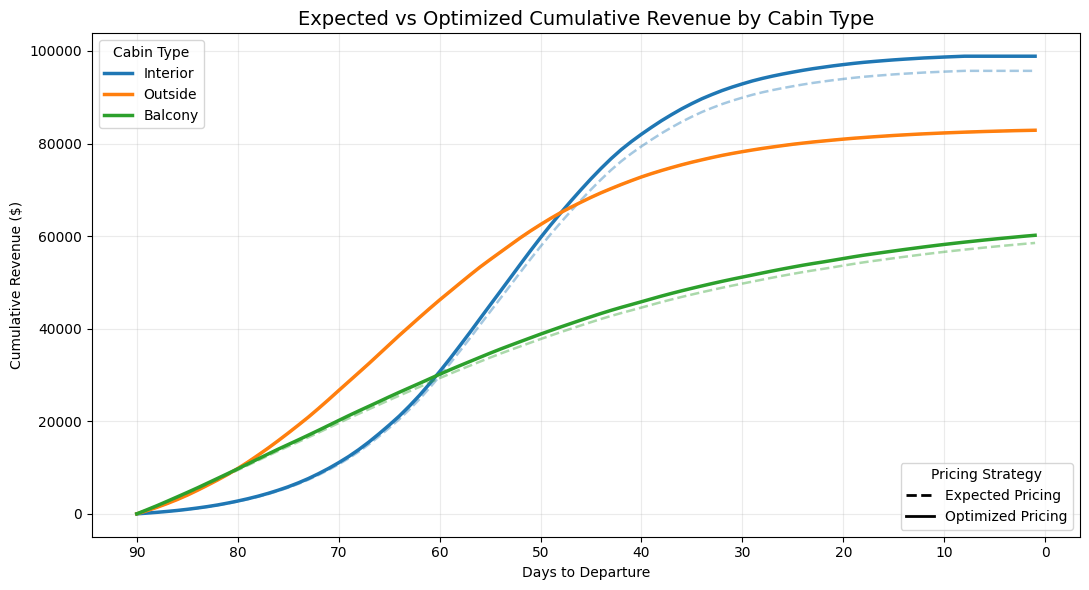

In [630]:
plot_df = df.sort_values(
    ["cabin_type", "days_to_departure"],
    ascending=[True, False]
)

cabin_colors = {
    "Interior": "#1f77b4",
    "Outside":  "#ff7f0e",
    "Balcony":  "#2ca02c"
}

plt.figure(figsize=(11, 6))

for cabin, color in cabin_colors.items():
    sub = plot_df[plot_df["cabin_type"] == cabin]

    # Expected (dashed)
    plt.plot(
        sub["days_to_departure"],
        sub["expected_cumulative_revenue"],
        linestyle="--",
        linewidth=1.8,
        color=color,
        alpha=0.4
    )

    # Optimized (solid)
    plt.plot(
        sub["days_to_departure"],
        sub["optimized_cumulative_revenue"],
        linestyle="-",
        linewidth=2.5,
        color=color,
        label=cabin
    )

plt.gca().invert_xaxis()
plt.xlabel("Days to Departure")
plt.ylabel("Cumulative Revenue ($)")
plt.title("Expected vs Optimized Cumulative Revenue by Cabin Type", fontsize=14)

cabin_legend = plt.legend(title="Cabin Type", loc="upper left")
plt.gca().add_artist(cabin_legend)

style_legend = [
    Line2D([0], [0], color="black", linestyle="--", linewidth=2,
           label="Expected Pricing"),
    Line2D([0], [0], color="black", linestyle="-", linewidth=2,
           label="Optimized Pricing")
]

plt.legend(handles=style_legend, title="Pricing Strategy", loc="lower right")

plt.grid(alpha=0.25)

ticks = list(range(
    int(plot_df["days_to_departure"].max()),
    -1,
    -10
))
plt.xticks(ticks)

plt.tight_layout()
plt.savefig(
    "../figures/04_expected_vs_optimized_revenue.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

In [631]:
df.head(10)

,date,days_to_departure,cabin_type,price,optimal_price,price_elasticity,total_inventory,remaining_inventory,expected_daily_bookings,expected_optimal_daily_bookings,expected_daily_revenue,optimized_daily_revenue,daily_revenue_uplift,expected_cumulative_revenue,optimized_cumulative_revenue
0,2025-10-21,90,Balcony,525.0,525.00,-0.8,100,100,0.00,0.00,0.00,0.000000,0.00,0.00,0.00
90,2025-10-21,90,Interior,263.0,263.00,-1.2,300,300,0.00,0.00,0.00,0.000000,0.00,0.00,0.00
180,2025-10-21,90,Outside,351.0,351.00,-1.0,200,200,0.00,0.00,0.00,0.000000,0.00,0.00,0.00
1,2025-10-22,89,Balcony,507.0,583.05,-0.8,100,100,1.68,1.50,851.76,875.904604,24.14,851.76,875.90
91,2025-10-22,89,Interior,265.0,225.25,-1.2,300,298,0.57,0.69,151.05,156.040360,4.99,151.05,156.04
181,2025-10-22,89,Outside,351.0,298.35,-1.0,200,192,1.94,2.28,680.94,680.940000,0.00,680.94,680.94
2,2025-10-23,88,Balcony,509.0,585.35,-0.8,100,98,1.70,1.52,865.30,889.828419,24.53,1717.06,1765.73
92,2025-10-23,88,Interior,264.0,224.40,-1.2,300,288,0.63,0.77,166.32,171.814848,5.49,317.37,327.86
182,2025-10-23,88,Outside,356.0,302.60,-1.0,200,191,2.06,2.42,733.36,733.360000,0.00,1414.30,1414.30
3,2025-10-24,87,Balcony,525.0,603.75,-0.8,100,97,1.74,1.56,913.50,939.394731,25.89,2630.56,2705.13
